# Assignment 4

### 1. 复习上课内容以及复现课程代码

在本部分，你需要复习上课内容和课程代码后，自己复现课程代码。

In [ ]:
import numpy as np


class Node:
    def __init__(self, inputs=[]):
        self.inputs = inputs
        self.outputs = []        

        for n in self.inputs:
            n.outputs.append(self)

        self.value = None
        
        self.gradients = {}
        
        

    def forward(self):

        raise NotImplemented
    

    def backward(self):

        raise NotImplemented
        
class Input(Node):
    def __init__(self):
        Node.__init__(self)

    def forward(self, value=None):

        if value is not None:
            self.value = value
        
    def backward(self):
        self.gradients = {self:0} # initialization 
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost * 1
            

class Add(Node):
    def __init__(self, *nodes):
        Node.__init__(self, nodes)


    def forward(self):
        self.value = sum(map(lambda n: n.value, self.inputs))

class Linear(Node):

    def __init__(self, nodes, weights, bias):
        Node.__init__(self, [nodes, weights, bias])

    def forward(self):
        #前向传播计算 y = w*x + b
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value

        self.value = np.dot(inputs, weights) + bias
        
    def backward(self):
        #反向传播计算
        # initial a partial for each of the inbound_nodes.
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            # Get the partial of the cost w.r.t this node.
            grad_cost = n.gradients[self]
            #以下分别计算对inputs， weights, bias的梯度
            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T)
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost)
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False)

        # WX + B / W ==> X
        # WX + B / X ==> W

class Sigmoid(Node):
    def __init__(self, node):
        Node.__init__(self, [node])


    def _sigmoid(self, x):
        return 1./(1 + np.exp(-1 * x))

    def forward(self):
        self.x = self.inputs[0].value   # [0] input is a list
        self.value = self._sigmoid(self.x)

    def backward(self):
        self.partial = self._sigmoid(self.x) * (1 - self._sigmoid(self.x))
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            grad_cost = n.gradients[self] 
            self.gradients[self.inputs[0]] = grad_cost * self.partial




class MSE(Node):
    def __init__(self, y, a):
        Node.__init__(self, [y, a])


    def forward(self):
        y = self.inputs[0].value.reshape(-1, 1)
        a = self.inputs[1].value.reshape(-1, 1)
        assert(y.shape == a.shape)

        self.m = self.inputs[0].value.shape[0]
        self.diff = y - a
        self.value = np.mean(self.diff**2)


    def backward(self):
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff


def forward_and_backward(outputnode, graph):
    for n in graph:
        n.forward()  

    for n in  graph[::-1]:
        n.backward()


def topological_sort(feed_dict):
    """
    Sort generic nodes in topological order using Kahn's Algorithm.
    `feed_dict`: A dictionary where the key is a `Input` node and the value is the respective value feed to that node.
    Returns a list of sorted nodes.
    """

    input_nodes = [n for n in feed_dict.keys()]

    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)

    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()

        if isinstance(n, Input):
            n.value = feed_dict[n]
            ## if n is Input Node, set n'value as 
            ## feed_dict[n]
            ## else, n's value is caculate as its
            ## inbounds

        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                S.add(m)
    return L


def sgd_update(trainables, learning_rate=1e-2):
    # there are so many other update / optimization methods
    # such as Adam, Mom, 
    for t in trainables:
        t.value += -1 * learning_rate * t.gradients[t]

### 2. 回答一下理论题目

#### 1. What does a neuron compute?

神经网络是模拟生物神经信号的传递过程，包含输入层、隐藏层、输出层，每个节点是一种输出函数，经过多层函数转换，输出结果

####  2. Why we use non-linear activation funcitons in neural networks?

如果使用线性函数，每一层输出都是上层输入的线性函数，无论神经网络有多少层，输出都是输入的线性组合。多层网络就没有意义了

#### 3. What is the 'Logistic Loss' ?

用来衡量模型预测结果和真实结果的误差 
$$ loss = \frac 1 n \Sigma{(y-\hat y)^2} $$

#### 4. Assume that you are building a binary classifier for detecting if an image containing cats, which activation functions would you recommen using for the output layer ?

A. ReLU    
B. Leaky ReLU    
C. sigmoid    
D. tanh  

C. sigmoid    

#### 5. Why we don't use zero initialization for all parameters ?

初始参数全为0，会导致下一层的参数和上一层一样，无法进行真正的学习和优化

#### 6. Can you implement the softmax function using python ? 

In [392]:
import math
def softmax(z):
    return 1.0 / (1 + math.exp(-z))
softmax(2)    

0.8807970779778823

### 3.实践题

#### In this practical part, you will build a simple digits recognizer to check if the digit in the image is larger than 5. This assignmnet will guide you step by step to finish your first small project in this course .

#### 1 - Packages  
sklearn is a famous package for machine learning.   
matplotlib is a common package for vasualization.

In [254]:
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#### 2 - Overvie of the dataset  
    - a training set has m_train images labeled as 0 if the digit < 5 or 1 if the digit >= 5
    - a test set contains m_test images labels as if the digit < 5 or 1 if the digit >= 5
    - eah image if of shape (num_px, num_px ). Thus, each image is square(height=num_px and  width = num_px)

In [255]:
# Loading the data 
digits = datasets.load_digits()
digits

{'data': array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  2., ..., 12.,  0.,  0.],
        [ 0.,  0., 10., ..., 12.,  1.,  0.]]),
 'target': array([0, 1, 2, ..., 8, 9, 8]),
 'target_names': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 'images': array([[[ 0.,  0.,  5., ...,  1.,  0.,  0.],
         [ 0.,  0., 13., ..., 15.,  5.,  0.],
         [ 0.,  3., 15., ..., 11.,  8.,  0.],
         ...,
         [ 0.,  4., 11., ..., 12.,  7.,  0.],
         [ 0.,  2., 14., ..., 12.,  0.,  0.],
         [ 0.,  0.,  6., ...,  0.,  0.,  0.]],
 
        [[ 0.,  0.,  0., ...,  5.,  0.,  0.],
         [ 0.,  0.,  0., ...,  9.,  0.,  0.],
         [ 0.,  0.,  3., ...,  6.,  0.,  0.],
         ...,
         [ 0.,  0.,  1., ...,  6.,  0.,  0.],
         [ 0.,  0.,  1., ...,  6.,  0.,  0.],
         [ 0.,  0.,  0., ..., 10.,  0.,  0.]],
 
        [[ 0

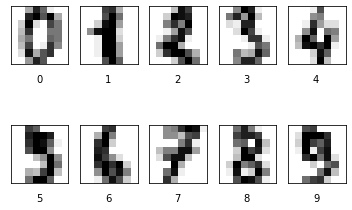

In [256]:
# Vilizating the data
for i in range(1,11):
#     一个 Figure 对象可以包含多个子图(Axes)
    plt.subplot(2,5,i)
#     显示灰度图像 以二元素向量 [low high] 形式指定显示范围
    plt.imshow(digits.data[i-1].reshape([8,8]),cmap=plt.cm.gray_r)
    plt.text(3,10,str(digits.target[i-1]))
#     设置刻度
    plt.xticks([])
    plt.yticks([])
plt.show()

In [257]:
# Split the data into training set and test set 
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.25)

In [258]:
# reformulate the label. 
# If the digit is smaller than 5, the label is 0.
# If the digit is larger than 5, the label is 1.

y_train[y_train < 5 ] = 0
y_train[y_train >= 5] = 1
y_test[y_test < 5] = 0
y_test[y_test >= 5] = 1

print(y_train)

[1 1 1 ... 1 0 1]


In [259]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1347, 64)
(450, 64)
(1347,)
(450,)


#### 3- Architecture of the neural network

![title](./networks.png)

In [260]:
!pwd

/Users/xiangjiejie/Mayday/AIStudy/lecture4


##### Mathematical expression of the algorithm:

For one example $x^{(i)}$:   
 $$ z^{(i)} = w^T * x^{(i)} +b $$   
 $$ y^{(i)} = a^{(i)} = sigmoid(z^{(i)})$$   
 $$L(a^{(i)},y^{(i)}) = -y^{(i)} log(a^{(i)})-(1-y^{(i)})log(1-a^{(i)})$$

The total cost over all training examples:
$$ J = \frac{1}{m}\sum_{i=1}^{m}L(a^{(i)},y^{(i)}) $$

#### 4 - Building the algorithm

##### 4.1- Activation function    
###### Exercise:
Finish the sigmoid funciton 

In [261]:
import numpy as np

In [262]:
def sigmoid(z):
    '''
    Compute the sigmoid of z
    Arguments: z -- a scalar or numpy array of any size.
    
    Return:
    s -- sigmoid(z)
    '''
    s = 1.0/(1 + np.exp(-z))
    
    return s

In [263]:
# Test your code 
# The result should be [0.5 0.88079708]
print("sigmoid([0,2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0,2]) = [0.5        0.88079708]


##### 4.1-Initializaing parameters
###### Exercise:
Finishe the initialize_parameters function below

In [264]:
a = np.random.randn(2,1)
a.shape


(2, 1)

In [333]:
# Random innitialize the parameters

def initialize_parameters(dim):
    '''
    Argument: dim -- size of the w vector
    
    Returns:
    w -- initialized vector of shape (dim,1)
    b -- initializaed scalar
    '''
    
    w = np.random.randn(dim,1)
#     todo
    b = 0.0
    
    assert(w.shape == (dim,1))
    assert(isinstance(b,float) or isinstance(b,int))
    
    return w,b
initialize_parameters(4)

(array([[-0.07521886],
        [ 0.80982253],
        [ 2.6234595 ],
        [ 0.75839671]]), 0.0)

#### 4.3-Forward and backward propagation

###### Some mathematical expressions
Forward Propagation:   
. X    
. A = $\sigma(w^T*X+b) = (a^{(1)},a^{(2)},...,a^{(m)}$   
. J = $-\frac{1}{m} \sum_{i=1}^{m}y^{(i)}log(a^{(i)}+(1-y^{(i)})log(1-a^{(i)})$       

Some derivative: 
$$\frac{\partial{J}}{\partial{w}} = \frac{1}{m}X*(A-Y)^T$$   
$$\frac{\partial{J}}{\partial{b}} = \frac{1}{m}\sum_{i=1}^m(a^{(i)}-y^{(i)}) $$

###### Exercise:
Finish the function below:

In [319]:

from icecream import ic
def propagate(w,b,X,Y):
    '''
    Implement the cost function and its gradient for the propagation
    
    Arguments:
    w - weights
    b - bias
    X - data
    Y - ground truth
    '''
    m = X.shape[1]

    A = sigmoid(np.dot( X,w) + b)

    cost = 0.0
    for i in range(m):
        if(A[i][0] != 0 and A[i][0] != 1):
            cost += -1 / m * (A[i][0] *np.log(A[i][0])+(1-Y[i]) * np.log(1-A[i][0]))
#     cost = sum(Y[i] * np.log(A[0][i] + (1-Y[i])*np.log(1-A[0][i])) for i in range(m))


    dw = np.dot(X.T,(A-Y.reshape(-1,1) )) / m

    db = sum(A-Y) / m

    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {'dw':dw,
             'db':db}
    return grads, cost

# model(X_train, y_train.reshape(-1,1), X_test,  y_test.reshape(-1,1), 20,0.1,print_cost=False)    

##### 4.4 -Optimization

###### Exercise:
Minimizing the cost function using gradient descent.   
$$\theta = \theta - \alpha*d\theta$$ where $\alpha$ is the learning rate.

In [334]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    '''
    This function optimize w and b by running a gradient descen algorithm
    
    Arguments:
    w - weights
    b - bias
    X - data
    Y - ground truth
    num_iterations -- number of iterations of the optimization loop 迭代次数
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params - dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    '''
    
    costs = []
    
    for i in range(num_iterations):
        
        grads, cost = propagate(w, b, X, Y)
        
        dw = grads['dw']
        db = grads['db']
        
        w = w - dw * learning_rate
        b = b - db * learning_rate
        
        if i % 100 == 0:
            costs.append(cost)
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w":w,
              "b":b}
    
    grads = {"dw":dw,
             "db":db}
    
    return params, grads, costs



###### Exercise
The previous function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X. Implement the predict() function.    
Two steps to finish this task:   
1. Calculate $\hat{Y} = A = \sigma(w^T*X+b)$   
2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector Y_prediction. If you wish, you can use an if/else statement in a for loop (though there is also a way to vectorize this).

In [321]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights
    b -- bias 
    X -- data 
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))

    A = sigmoid(w.T * X + b)
    
    for i in range(A.shape[1]):
        if A[0][i] <= 0.5:
            Y_prediction[0][i] = 0
        else:
            Y_prediction[0][i] = 1
    
    assert(Y_prediction.shape == (1,m))
    
    return Y_prediction

# model(X_train, y_train.reshape(-1,1), X_test,  y_test.reshape(-1,1), 20,0.1,print_cost=False)    

##### 5- Merge all functions into a model

Congratulations !! You have finished all the necessary components for constructing a model. Now, Let's take the challenge to merge all the implemented function into one model.

In [402]:
def model(X_train, Y_train, X_test, Y_test, num_iterations, learning_rate,print_cost):
    """
    Build the logistic regression model by calling all the functions you have implemented.
    Arguments:
    X_train - training set
    Y_train - training label
    X_test - test set
    Y_test - test label
    num_iteration - hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d - dictionary should contain following information w,b,training_accuracy, test_accuracy,cost
    eg: d = {"w":w,
             "b":b,
             "training_accuracy": traing_accuracy,
             "test_accuracy":test_accuracy,
             "cost":cost}
    """
#     w_buffer = []
#     b_buffer = []
    m = X_train.shape[1]
#   todo:  X_train.shape[0] ? X_train.shape[1]
    w, b = initialize_parameters(X_train.shape[1])

    A = sigmoid(np.dot(X_train,w) + b)

    
        
    cost,traing_accuracy,test_accuracy = [],[],[]
#     print('Y_train',Y_train.reshape(1,-1))
#     todo: 迭代次数取什么值？
    for i in range(num_iterations):
        params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate)
        w, b = params['w'], params['b']

    
#         A = sigmoid(np.dot(X_train,w) + b)
        Y_train_prediction = predict(w,b,X_train)
        Y_test_prediction = predict(w,b,X_test)
#       todo: 不太对
        _cost = ( -1.0 / Y_train_prediction.shape[1]) * sum(np.square( Y_test_prediction[0][i] - Y_train_prediction[0][i]) for i in range(Y_train_prediction.shape[1]))
        cost.append(_cost)
        train_accuracy_count,test_accuracy_count = 0,0
        for y_train,Y_test, a in zip(np.squeeze(Y_train_prediction),np.squeeze(Y_test_prediction),np.squeeze(Y_train.reshape(1,-1))):
#             print('y_train',y_train,a)
            if y_train == a:
                train_accuracy_count = train_accuracy_count+1
            if Y_test == a:
                test_accuracy_count = test_accuracy_count+1

        traing_accuracy.append(train_accuracy_count/Y_train_prediction.shape[1])
        test_accuracy.append(test_accuracy_count/Y_test_prediction.shape[1])
        
    d = {"w":w,
         "b":b,
         "training_accuracy": traing_accuracy,
         "test_accuracy":test_accuracy,
         "cost":cost}
        
    return d
    
data = model(X_train, y_train.reshape(-1,1), X_test,  y_test.reshape(-1,1), 20,0.1,print_cost=False)    
data


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':


{'w': array([[ -0.36536833],
        [ -4.17822982],
        [  6.14354387],
        [ -8.05386694],
        [ 15.22449801],
        [ 16.14128767],
        [ 22.33757906],
        [  1.19409988],
        [  2.39867782],
        [-23.34887515],
        [ 19.95445536],
        [ 14.72607384],
        [ -3.33040838],
        [-10.25063228],
        [  3.33229845],
        [  3.09481633],
        [ -2.3768712 ],
        [  8.79460508],
        [ 30.58514951],
        [ -9.66479208],
        [-48.57896022],
        [-11.79675512],
        [-21.37748946],
        [ -4.09184361],
        [ -2.1422782 ],
        [-30.25859201],
        [  3.24869895],
        [ 43.85698929],
        [  6.582504  ],
        [ 30.78962042],
        [-31.4454211 ],
        [ -2.03614133],
        [  1.6711082 ],
        [-55.36502287],
        [ -0.14180927],
        [ 22.42091322],
        [-12.03922958],
        [ -6.30544929],
        [ 11.18393376],
        [ -0.44334526],
        [ -0.38467471],
        [-1

### 4.选做题

Congratulations on building your first logistic regression model. It is your time to analyze it further.

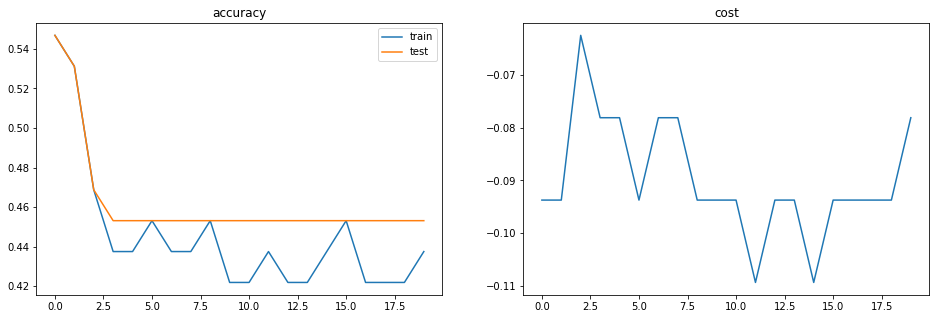

In [404]:
def model_plot(d):
    training_accuracy = d["training_accuracy"]
    test_accuracy = d["test_accuracy"]
    costs = d["cost"]
    plt.figure(figsize=(16, 5))
    ax1 = plt.subplot(1, 2, 1)
    plt.plot(range(len(training_accuracy)), training_accuracy)
    plt.plot(range(len(test_accuracy)), test_accuracy)
    plt.title("accuracy")
    plt.legend(["train","test"])
    ax2 = plt.subplot(1, 2, 2)
    plt.plot(range(len(costs)), costs)
    plt.title("cost")
    
model_plot(data)    

##### 4.1 Observe the effect of learning rate on the leraning process.   
Hits: plot the learning curve with different learning rate

##### 4.2 Observe the effect of iteration_num on the test accuracy.

# Challenge ! ! !

The original data have images labeled 0,1,2,3,4,5,6,7,8,9. In our logistic model, we only detect if the digit in the image is larger or smaller than 5. Now, Let's go for a more challenging problem. Try to use softmax function to build a model to recognize which digit (0,1,2,3,4,5,6,7,8,9) is in the image.

# Congratulations ! You have completed assigment 4. 